c:\Users\Admin\OneDrive\Documents\-o_An_1-master 1


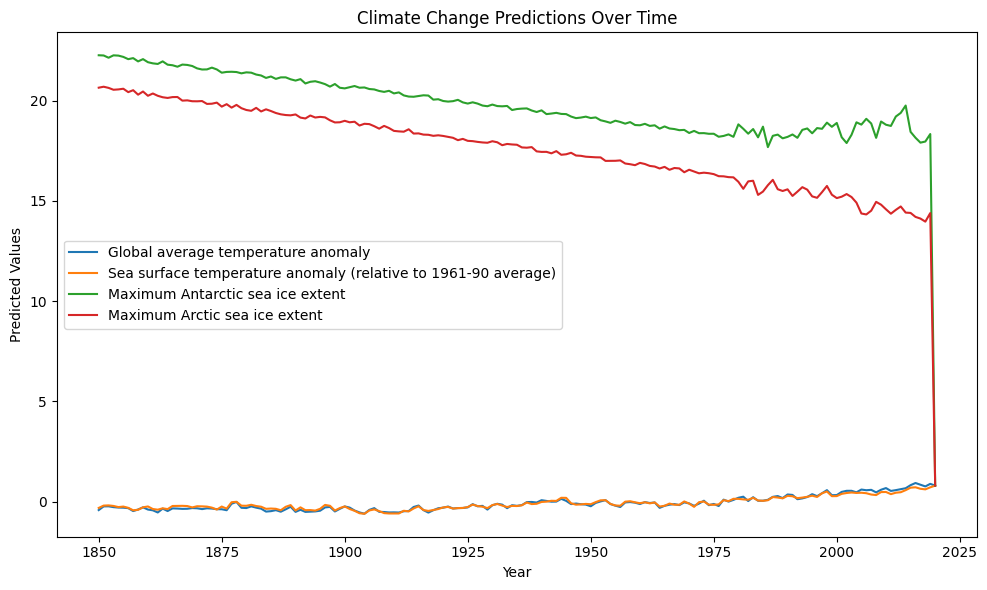

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
from utils import predicted_causes_file, load_model, save_model

# =======================Hàm dự đoán các biến nguyên nhân và tạo file predicted_causes.csv với năm được chọn==========================

def predict_single_year(year, model, predicted_data, feature_columns, cause_columns):
    future_years = pd.DataFrame({'year': [year]})
    predictions = {}
    
    for column in cause_columns:
        X = predicted_data[feature_columns]
        y = predicted_data[column]
        model.fit(X, y)
        future_prediction = model.predict(future_years)
        predictions[column] = future_prediction[0]
    
    return year, predictions

def predict_causes(csv_file_path, target_year):
    # Đọc dữ liệu từ file CSV
    climate_data = pd.read_csv(csv_file_path)
    
    # Các biến nguyên nhân cần dự đoán
    cause_columns = ['greenhouse gas emissions person', 'methane emissions person', 'nitrous oxide emissions person', 'Annual CO2 emission', 'Annual greenhouse gas emissions','Annual nitrous emissions']
    
    # Cột đặc trưng (đặc điểm dựa trên đó để dự đoán)
    feature_columns = ['year']

    # Lấy năm cuối cùng từ dữ liệu hiện tại
    last_year = climate_data['year'].max()

    # Sao chép dữ liệu hiện tại để dự đoán
    predicted_data = climate_data.copy()

    # Kiểm tra xem model đã được lưu chưa
    model = load_model('linear_regression_model.pkl')  # Thay thế bằng tên file lưu trữ model của bạn
    
    # Nếu model chưa tồn tại, huấn luyện lại và lưu model
    if model is None:
        print("No saved model found. Training a new model...")
        model = LinearRegression()
        # Huấn luyện mô hình với toàn bộ dữ liệu hiện tại để dự đoán cho tương lai
        X_train = predicted_data[feature_columns]
        y_train = predicted_data[cause_columns]
        model.fit(X_train, y_train)
        # Lưu mô hình đã huấn luyện
        save_model(model, 'linear_regression_model.pkl')
        print("New model trained and saved.")
    else:
        print("Loaded saved model.")

    # Sử dụng Parallel processing để dự đoán cho các năm từ last_year đến target_year
    results = Parallel(n_jobs=4)(delayed(predict_single_year)(
        year, model, predicted_data, feature_columns, cause_columns
    ) for year in range(last_year + 1, target_year + 1))

    # Thêm các dự đoán vào dữ liệu dự đoán
    for year, predictions in results:
        new_row = {'year': year}
        new_row.update(predictions)
        predicted_data = pd.concat([predicted_data, pd.DataFrame([new_row])], ignore_index=True)

    # Lưu dữ liệu dự đoán vào file predicted_causes.csv
    predicted_data.to_csv(predicted_causes_file, index=False)
    print(f"Predicted cause variables from {last_year} to {target_year} saved to '{predicted_causes_file}'")


import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from utils import predicted_causes_file, load_model, save_model
import joblib

#===================================Hàm này để huấn luyện mô hình==========================================================>




#=========================================================================================================================>



#------------------------------------Hàm trả về dữ liệu để vẽ biểu đồ----------------------------------------------------->
def get_visualization_data(climate_data):
    data = {
        'years': climate_data['year'].tolist(),
        'greenhouse gas emissions person': climate_data['greenhouse gas emissions person'].tolist() if 'greenhouse gas emissions person' in climate_data.columns else [],
        'methane emissions person': climate_data['methane emissions person'].tolist(),
        'nitrous oxide emissions person': climate_data['nitrous oxide emissions person'].tolist(),
        'Annual CO2 emission': climate_data['Annual CO2 emission'].tolist(),
        'Annual greenhouse gas emissions': climate_data['Annual greenhouse gas emissions'].tolist(),
        'Annual nitrous emissions': climate_data['Annual nitrous emissions'].tolist()
    }
    return data



import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split  # Để chia dữ liệu thành training/test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Các chỉ số đánh giá
from utils import predicted_causes_file, save_model
import joblib

def train_and_predict_with_all_data(csv_file, predicted_causes_file, target_year=None):
    # Đọc dữ liệu từ file CSV
    train_data = pd.read_csv(csv_file)
    predicted_data = pd.read_csv(predicted_causes_file)

    # Sử dụng toàn bộ dữ liệu trong train_data, ngoại trừ cột 'year' làm trục X (input features)
    feature_columns = [col for col in train_data.columns if col != 'year' and col != 'target']  # Đảm bảo không bao gồm cột 'year' hoặc cột mục tiêu
    target_columns = ['target']  # Cột mà bạn muốn dự đoán (có thể là nhiều cột)

    # Kiểm tra nếu các cột mục tiêu không tồn tại thì thêm các cột với giá trị None
    for target_col in target_columns:
        if target_col not in train_data.columns:
            train_data[target_col] = None

    # Nếu target_year không được chỉ định, sử dụng toàn bộ dữ liệu
    if target_year is None:
        target_year = train_data['year'].max()  # Sử dụng năm cuối cùng có trong dữ liệu nếu không chỉ định

    # Tạo X_train và y_train
    X = train_data[feature_columns].dropna().astype(float)
    y = train_data[target_columns].dropna().astype(float)

    # Làm sạch dữ liệu trước khi huấn luyện
    train_data.fillna(0, inplace=True)

    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    # Chia dữ liệu thành bộ huấn luyện và bộ kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Chia 80% cho training, 20% cho testing

    # Huấn luyện mô hình với RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Dự đoán trên bộ dữ liệu kiểm tra
    y_pred = model.predict(X_test)

    # Đánh giá độ chính xác của mô hình
    mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
    mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
    r2 = r2_score(y_test, y_pred)  # R-squared score

    # In kết quả đánh giá
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

    # Dự đoán cho toàn bộ dữ liệu của predicted_causes_file
    for target_col in target_columns:
        # Dự đoán cho từng cột mục tiêu (target column)
        predicted_value = model.predict(predicted_data[feature_columns])
        predicted_data[target_col] = predicted_value

    # Lưu lại dữ liệu đã được dự đoán vào file predicted_causes_file
    predicted_data.to_csv(predicted_causes_file, index=False)

    # Lưu mô hình đã huấn luyện
    save_model(model, 'climate_change_impact_model.pkl')
    print(f"Mô hình đã được huấn luyện và lưu thành công với các biến: {target_columns}")

    return predicted_data

#------------------------------------------------------------------------------------------------------------------------->

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu từ predicted_causes_file
predicted_data = pd.read_csv(predicted_causes_file)  # Đảm bảo đường dẫn đúng

# Chọn các cột cần vẽ (ví dụ: 'year' và các cột mục tiêu)
target_columns = ['Global average temperature anomaly', 
                  'Sea surface temperature anomaly (relative to 1961-90 average)', 
                  'Maximum Antarctic sea ice extent', 
                  'Maximum Arctic sea ice extent']

# Vẽ biểu đồ đường cho từng cột mục tiêu
plt.figure(figsize=(10, 6))

for target_col in target_columns:
    if target_col in predicted_data.columns:
        plt.plot(predicted_data['year'], predicted_data[target_col], label=target_col)

# Thêm tiêu đề, nhãn trục, và hiển thị legend
plt.title('Climate Change Predictions Over Time')
plt.xlabel('Year')
plt.ylabel('Predicted Values')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split  # Để chia dữ liệu thành training/test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Các chỉ số đánh giá
from utils import predicted_causes_file, save_model
import joblib

def train_and_predict_with_all_data(csv_file, predicted_causes_file, target_year=None):
    # Đọc dữ liệu từ file CSV
    train_data = pd.read_csv(csv_file)
    predicted_data = pd.read_csv(predicted_causes_file)

    # Sử dụng toàn bộ dữ liệu trong train_data, ngoại trừ cột 'year' làm trục X (input features)
    feature_columns = [col for col in train_data.columns if col != 'year' and col != 'target']  # Đảm bảo không bao gồm cột 'year' hoặc cột mục tiêu
    target_columns = ['target']  # Cột mà bạn muốn dự đoán (có thể là nhiều cột)

    # Kiểm tra nếu các cột mục tiêu không tồn tại thì thêm các cột với giá trị None
    for target_col in target_columns:
        if target_col not in train_data.columns:
            train_data[target_col] = None

    # Nếu target_year không được chỉ định, sử dụng toàn bộ dữ liệu
    if target_year is None:
        target_year = train_data['year'].max()  # Sử dụng năm cuối cùng có trong dữ liệu nếu không chỉ định

    # Tạo X_train và y_train
    X = train_data[feature_columns].dropna().astype(float)
    y = train_data[target_columns].dropna().astype(float)

    # Làm sạch dữ liệu trước khi huấn luyện
    train_data.fillna(0, inplace=True)

    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    # Chia dữ liệu thành bộ huấn luyện và bộ kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Chia 80% cho training, 20% cho testing

    # Huấn luyện mô hình với RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Dự đoán trên bộ dữ liệu kiểm tra
    y_pred = model.predict(X_test)

    # Đánh giá độ chính xác của mô hình
    mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
    mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
    r2 = r2_score(y_test, y_pred)  # R-squared score

    # In kết quả đánh giá
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

    # Dự đoán cho toàn bộ dữ liệu của predicted_causes_file
    for target_col in target_columns:
        # Dự đoán cho từng cột mục tiêu (target column)
        predicted_value = model.predict(predicted_data[feature_columns])
        predicted_data[target_col] = predicted_value

    # Lưu lại dữ liệu đã được dự đoán vào file predicted_causes_file
    predicted_data.to_csv(predicted_causes_file, index=False)

    # Lưu mô hình đã huấn luyện
    save_model(model, 'climate_change_impact_model.pkl')
    print(f"Mô hình đã được huấn luyện và lưu thành công với các biến: {target_columns}")

    return predicted_data


c:\Users\Admin\OneDrive\Documents\-o_An_1-master 1
